In [1]:
# for switching between GPU and CPU
NO_GPU = False

if NO_GPU:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as kl
from keras.preprocessing.image import ImageDataGenerator
import scipy
import skimage, skimage.draw, skimage.transform
import random

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build_model(*layers, verbose=False,
               optimizer='adam', loss='categorical_crossentropy', metrics=['acc'],
               compile_kwargs={}):
    
    model = keras.models.Sequential()
    
    for layer in layers:
        model.add(layer)
        
    if verbose:
        print("Model summary:")
        model.summary()
    
    for kw in ('optimizer', 'loss', 'metrics'):
        if not kw in compile_kwargs:
            compile_kwargs[kw] = locals()[kw]
    model.compile(**compile_kwargs)
    
    return model

In [3]:
def plot_history(history, figsize=(15,4), title='', columns=2, start_x_from=0):
    """Graphs a history for each key (combines validation and training keys into one plot).
    
    start_x_from=N skips the first N entries.
    
    History can be a whole training history class or just a dict."""
    
    if hasattr(history, 'history'): # full history given
        history = history.history   # only that history is enough
        
    assert hasattr(history, 'keys')
    keys = [key for key in history.keys() if not key.startswith("val_")]
    assert keys # there is one at least
    epochs = list(range(1,len(history[keys[0]])+1)) # all should have the same size list
    
    rows = np.ceil(len(keys)/columns).astype('int')
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    i = 1
    for key in sorted(keys):
        valkey = "val_" + key
        fig.add_subplot(rows, columns, i)
        i += 1
        plt.plot(epochs[start_x_from:], history[key][start_x_from:], label="Training " + key,
                 marker='.', color='#00A287', linestyle='')
        
        late_avg = np.mean(history[key][(len(history[key]) * 90) // 100 : ])
        plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                 color="#74E600", label='Mean {:.3f}'.format(late_avg))
        if valkey in history:
            plt.plot(epochs[start_x_from:], history[valkey][start_x_from:], label='Validation ' + key,
                    marker='+', color='#DF004F', linestyle='')
            
            late_avg = np.mean(history[valkey][(len(history[valkey]) * 90) // 100 : ])
            plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                     color="#FF6700", label='Mean {:.3f}'.format(late_avg))
        plt.legend()
        
    plt.show()

In [4]:
def show_imgs(images, columns=9, figsize=(15,7), title=''):
    """Displays images in a grid"""
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    rows = np.ceil(len(images)/columns).astype('int')
    
    for i in range(1, len(images)+1):
        fig.add_subplot(rows, columns, i)
        f = plt.imshow(images[i-1], cmap=plt.cm.binary)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        
    plt.show()

In [5]:
def all_same_length(*args):
    """Returns True if all arguments have equal len(.)"""
    return all(len(a) == len(args[0]) for a in args)

def shuffle_together(*numpy_arrays):
    """Shuffles numpy arrays in unison, returns a tuple.
    
    (applies the same random permutation to all of them,
    so they have to be the same length on axis=0)"""
    
    assert all_same_length(*numpy_arrays)
    permut = np.random.permutation(len(numpy_arrays[0]))
    return tuple(a[permut] for a in numpy_arrays)

In [6]:
def feature_smoothen(img):
    i = scipy.ndimage.filters.gaussian_filter(img, 0.16)
    #i = scipy.ndimage.filters.uniform_filter(img)
    #i = restoration.denoise_tv_chambolle(img)
    return i * (i > 0.2)

def feature_sobel(img):
    return scipy.ndimage.filters.sobel(img)
    
def feature_remove_dust(img):
    out_img = img.copy()
    labeled_img, nobjs = scipy.ndimage.label(img)
    if nobjs > 1: 
        label_count_pairs = zip(*np.unique(labeled_img, return_counts=1))
        label_count_pairs = sorted(label_count_pairs, key=lambda x: x[1], reverse=1)
        
        mask = np.zeros(img.shape)
        for i in range(nobjs):
            label, count = label_count_pairs[i]
            if i < 2 or count > 15:
                mask += (labeled_img == label)
        out_img *= mask
    return out_img

In [10]:
def feature_autoscale(img):
    img = img.copy()

    while not any(img[   0]): img = img[1:]
    while not any(img[  -1]): img = img[ :-1]
    while not any(img[:, 0]): img = img[:,1:]
    while not any(img[:,-1]): img = img[:, :-1]

    return skimage.transform.resize(img, (28,28))

In [11]:
def normalize_arr(arr):
    return arr / np.max(arr)

def feature_histogram_vert(img):
    return normalize_arr(np.apply_along_axis(sum, 0, img))

def feature_histogram_horiz(img):
    return normalize_arr(np.apply_along_axis(sum, 1, img))

EDGES = []
EDGES.extend([(i,  0) for i in range(13, -1, -1)])
EDGES.extend([(0 , i) for i in range(28)])
EDGES.extend([(i, 27) for i in range(28)])
EDGES.extend([(27, i) for i in range(27, -1, -1)])
EDGES.extend([(i,  0) for i in range(27, 13, -1)])
MIDDLES = tuple((13 + c0 // 14, 13 + c1 // 14) for c0, c1 in EDGES)
LINES = tuple(map(lambda m, e: skimage.draw.line_aa(*m,*e), MIDDLES, EDGES))

def feature_histogram_circ(img):
    sum_point = lambda r,c,v: v*img[r,c]
    sum_line = lambda line: sum(map(sum_point, *line))
    return normalize_arr(np.array(tuple(map(sum_line, LINES))))

In [43]:
### Import the dataset & apply transformations
from urllib.request import urlretrieve
filename, headers = urlretrieve(
    'https://github.com/Avatust/my-mnist-digits/raw/master/data/digits.npz')

with np.load(filename) as data:
    x_test = data['input_data']
    y_test = data['target_data']

(x_train, y_train), (x_valid, y_valid) = keras.datasets\
                                        .mnist.load_data()


y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)
y_test = keras.utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.0
x_valid = x_valid.astype('float32') / 255.0
x_test  =  x_test.astype('float32') / 255.0

preprocess = lambda x: feature_remove_dust(feature_smoothen(x))
x_train = np.array([preprocess(x) for x in x_train]) 
x_valid = np.array([preprocess(x) for x in x_valid]) 
x_test  = np.array([preprocess(x) for x in x_test ]) 
    
x_train = x_train.reshape(*x_train.shape, 1)
x_valid = x_valid.reshape(*x_valid.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)

INPUT_SHAPE = x_train[0].shape
VERBOSE=True
FIT_SETS = dict(x=x_train, y=y_train, validation_data=(x_valid, y_valid))
STATS_STR = ('Last epoch {epoch:}\t|'     '  Training  |'          '  Validation  |{nl:}'  
             'Loss \t\t|'          '  {loss[0]: 8.4f}  |''  {val_loss[0]: 10.4f}  |{nl:}'
             'Acc  \t\t|'           '  {acc[0]: 8.4f}  |' '  {val_acc[0]: 10.4f}  |')
BS = 500
EPOCHS=50
GEN_KWARGS = {} #dict(samplewise_center=True, samplewise_std_normalization=True)

train_gen = ImageDataGenerator(**GEN_KWARGS, rotation_range=20,
                               width_shift_range=0.13, height_shift_range=0.13,
                               shear_range=0.2, zoom_range=0.1,
                               fill_mode='constant', cval=0.0,
                               data_format='channels_last', preprocessing_function=feature_autoscale)
train_data_flow = train_gen.flow(x_train, y_train, batch_size=BS)
valid_data_flow = train_gen.flow(x_valid, y_valid, batch_size=BS)

test_gen = ImageDataGenerator(**GEN_KWARGS, preprocessing_function=feature_autoscale)
test_data_flow = test_gen.flow(x_test, y_test, batch_size=BS)

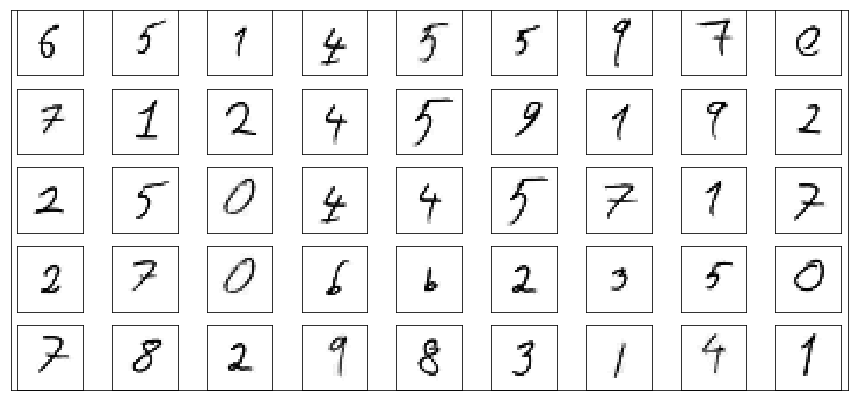

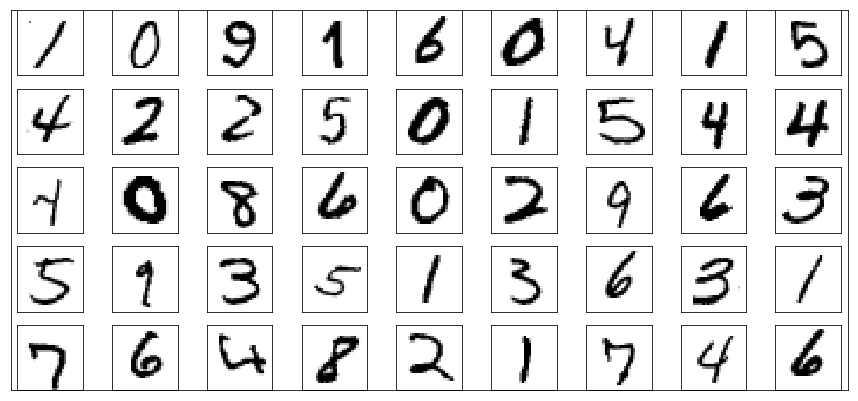

In [8]:
show_imgs([random.choice(x_test).reshape(28,28) for i in range(45)])
show_imgs([random.choice(x_train).reshape(28,28) for i in range(45)])

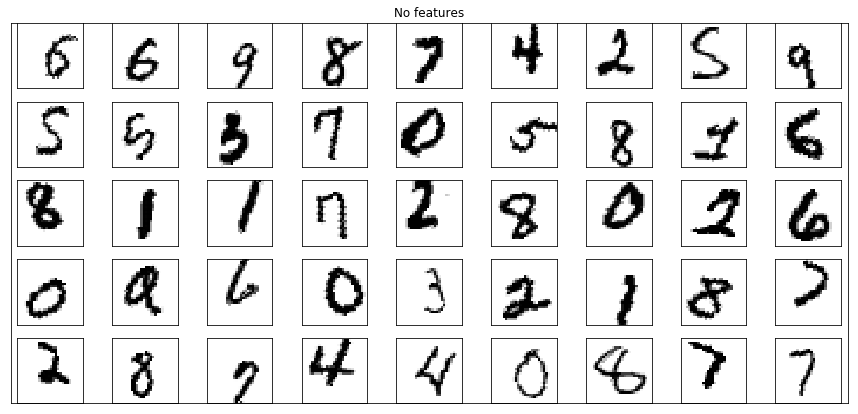

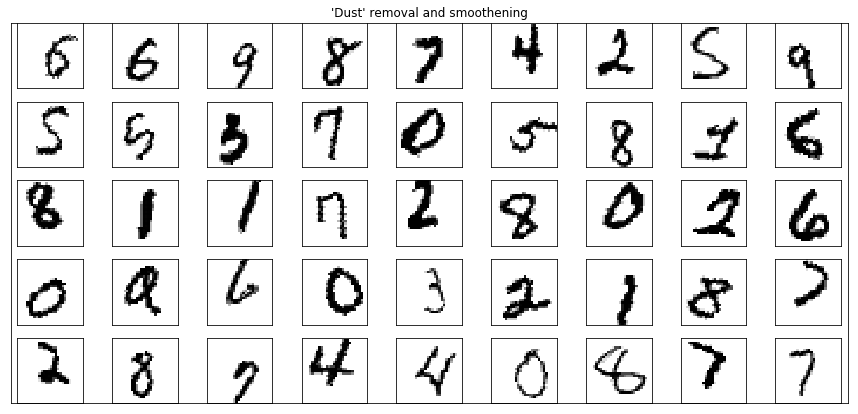

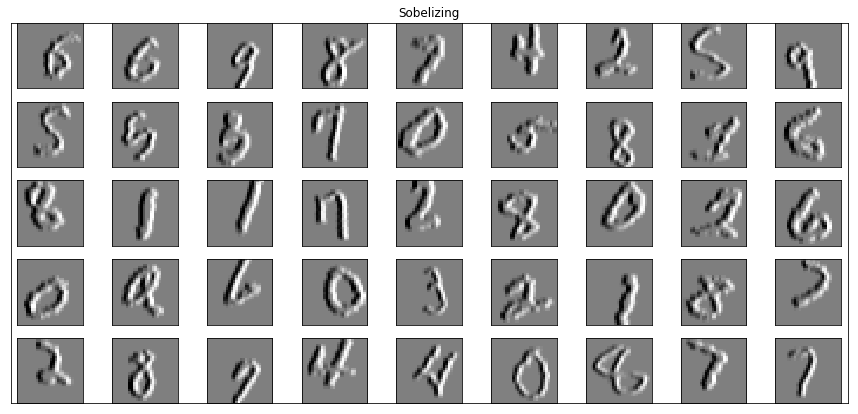

In [12]:
examples = train_data_flow.next()[0][:45].reshape(-1, 28,28)
show_imgs(examples, title='No features')
show_imgs([feature_remove_dust(feature_smoothen(e)) for e in examples], title="'Dust' removal and smoothening")
show_imgs([feature_sobel(feature_remove_dust(feature_smoothen(e))) for e in examples], title="Sobelizing")

/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


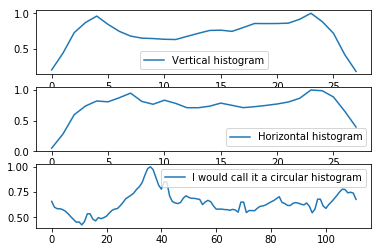

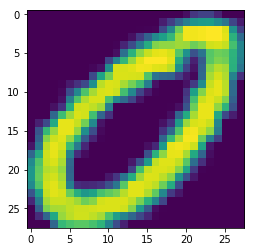

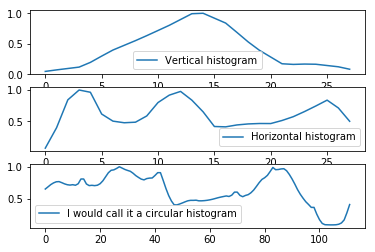

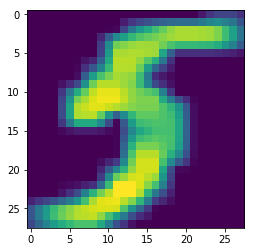

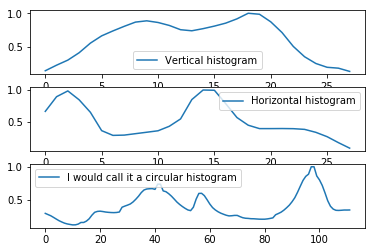

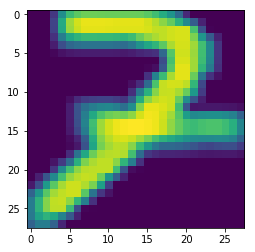

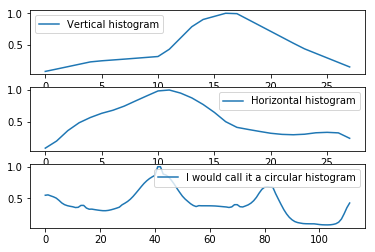

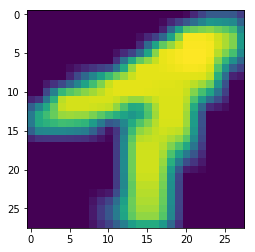

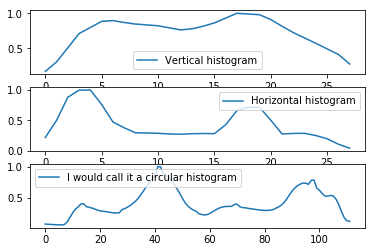

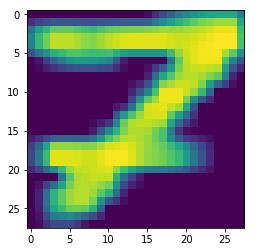

In [13]:
for i in range(5):
    im = random.choice(x_test).reshape(28,28)
    im = scipy.ndimage.grey_dilation(im, (2,2))
    im = feature_smoothen(im)
    im = feature_remove_dust(im)
    im = feature_autoscale(im)
    
    plt.subplot(311)
    plt.plot(feature_histogram_vert(im), label='Vertical histogram')
    plt.legend()
    
    plt.subplot(312)
    plt.plot(feature_histogram_horiz(im), label='Horizontal histogram')
    plt.legend()
    
    plt.subplot(313)
    plt.plot(feature_histogram_circ(im), label='I would call it a circular histogram')
    plt.legend()
    plt.show()

    plt.imshow(im)
    plt.show()


In [14]:
# baseline (validation accuracy about 0.90)
# its siblings were reaching accuracy up to 0.92 (and blazingly fast to train)
model_simple = build_model(
    kl.InputLayer(INPUT_SHAPE),
    
    kl.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    kl.MaxPool2D(pool_size=2, strides=2),
    
    kl.Flatten(),
    
    kl.Dense(units=64, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_simple = model_simple.fit(**FIT_SETS, epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                100416    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 101,146
Trainable params: 101,146
Non-tr

60000/60000 [==============================] - 1s 20us/step - loss: 0.0051 - acc: 0.9993 - val_loss: 0.0588 - val_acc: 0.9845
Epoch 46/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0046 - acc: 0.9995 - val_loss: 0.0616 - val_acc: 0.9856
Epoch 47/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0045 - acc: 0.9994 - val_loss: 0.0644 - val_acc: 0.9839
Epoch 48/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0042 - acc: 0.9994 - val_loss: 0.0694 - val_acc: 0.9828
Epoch 49/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.0061 - acc: 0.9986 - val_loss: 0.0612 - val_acc: 0.9850
Epoch 50/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0634 - val_acc: 0.9845


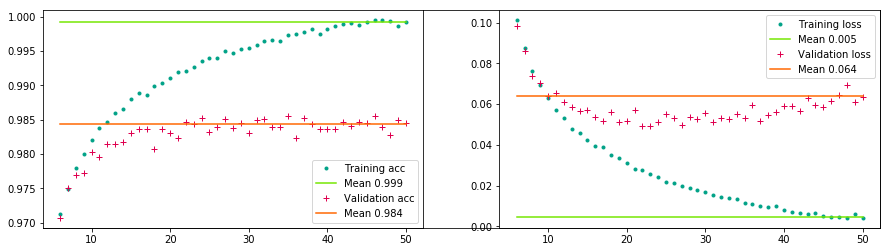

In [53]:
plot_history(hist_simple, start_x_from=5)

In [55]:
model_simple.evaluate(x_test, y_test)

172/172 [==============================] - 0s 143us/step


[3.421183924342311, 0.4534883707068687]

In [16]:
# LeNet-5 (accuracy up to 0.90)
model_lenet5 = build_model(
    kl.InputLayer(INPUT_SHAPE),
    
    kl.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same'),
    kl.MaxPool2D(pool_size=2, strides=2),
    
    kl.Conv2D(filters=16, kernel_size=5, activation='relu', padding='valid'),
    kl.MaxPool2D(pool_size=2, strides=2),
    
    kl.Flatten(),
    
    kl.Dense(units=120, activation='relu'),
    kl.Dense(units=84, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_lenet5 = model_lenet5.fit(**FIT_SETS, epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               48120 

Epoch 49/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0019 - acc: 0.9994 - val_loss: 0.0430 - val_acc: 0.9908
Epoch 50/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0036 - acc: 0.9988 - val_loss: 0.0465 - val_acc: 0.9898


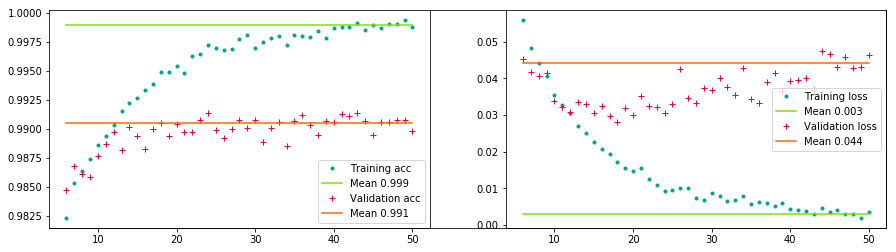

In [17]:
plot_history(hist_lenet5, start_x_from=5)

In [18]:
model_lentil = build_model(
    kl.InputLayer(INPUT_SHAPE),

    kl.Conv2D(filters=20, kernel_size=5, padding='same', activation='relu'),
    kl.MaxPool2D(pool_size=2, strides=2),


    kl.Conv2D(filters=50, kernel_size=5, padding='same', activation='relu'),
    kl.MaxPool2D(pool_size=2, strides=2),

    kl.Flatten(),

    kl.Dense(units=500, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_lentil = model_lentil.fit(**FIT_SETS, epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               122550

60000/60000 [==============================] - 4s 71us/step - loss: 2.7540e-04 - acc: 1.0000 - val_loss: 0.0333 - val_acc: 0.9937
Epoch 49/50
60000/60000 [==============================] - 4s 71us/step - loss: 2.7471e-04 - acc: 1.0000 - val_loss: 0.0335 - val_acc: 0.9937
Epoch 50/50
60000/60000 [==============================] - 4s 71us/step - loss: 2.7415e-04 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 0.9937


In [ ]:
print('Eval:', model_lentil.evaluate(x_test,y_test))


plot_history(hist_lentil, start_x_from=5)

In [48]:
# quite poor just about 0.915
# LeNet
# https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/
model_lenet_reg = build_model(
    kl.InputLayer(INPUT_SHAPE),

    kl.Conv2D(filters=20, kernel_size=5, padding='same', activation='relu'),
    kl.Conv2D(filters=40, kernel_size=3, padding='same', activation='relu'),
    kl.Dropout(0.2),
    kl.MaxPool2D(pool_size=2, strides=2),


    kl.Conv2D(filters=50, kernel_size=5, padding='same', activation='relu'),
    kl.Dropout(0.3),
    kl.MaxPool2D(pool_size=2, strides=2),

    kl.Flatten(),

    kl.Dropout(0.3),
    kl.Dense(units=200, activation='relu'),
    kl.Dense(units=80, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_lenet_reg = model_lenet_reg.fit_generator(generator=train_data_flow,
                                    validation_data=valid_data_flow,
                                    steps_per_epoch=len(x_train) // BS,
                                    epochs=30, verbose=1)

Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 20)        520       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 28, 28, 40)        7240      
_________________________________________________________________
dropout_40 (Dropout)         (None, 28, 28, 40)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 14, 14, 40)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 14, 14, 50)        50050     
_________________________________________________________________
dropout_41 (Dropout)         (None, 14, 14, 50)        0     

/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


120/120 [==============================] - 55s 457ms/step - loss: 0.4280 - acc: 0.8700 - val_loss: 0.1818 - val_acc: 0.9582
Epoch 2/30
120/120 [==============================] - 50s 421ms/step - loss: 0.1244 - acc: 0.9628 - val_loss: 0.1168 - val_acc: 0.9743
Epoch 3/30
120/120 [==============================] - 50s 419ms/step - loss: 0.0909 - acc: 0.9729 - val_loss: 0.0897 - val_acc: 0.9792
Epoch 4/30
120/120 [==============================] - 51s 425ms/step - loss: 0.0777 - acc: 0.9769 - val_loss: 0.0779 - val_acc: 0.9800
Epoch 5/30
120/120 [==============================] - 51s 425ms/step - loss: 0.0693 - acc: 0.9791 - val_loss: 0.0705 - val_acc: 0.9826
Epoch 6/30
120/120 [==============================] - 52s 435ms/step - loss: 0.0607 - acc: 0.9814 - val_loss: 0.0683 - val_acc: 0.9832
Epoch 7/30
120/120 [==============================] - 51s 429ms/step - loss: 0.0579 - acc: 0.9833 - val_loss: 0.0560 - val_acc: 0.9855
Epoch 8/30
120/120 [==============================] - 56s 464ms/st

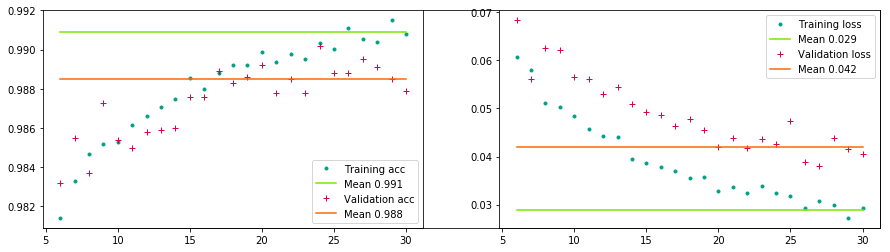

In [51]:
plot_history(hist_lenet_reg, start_x_from=5)

In [52]:
model_lenet_reg.evaluate_generator(test_data_flow)

/usr/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[0.20367178320884705, 0.9360465407371521]

In [ ]:
x_hh = x_train 
    
model_just_dense = build_model(
    kl.InputLayer(INPUT_SHAPE),
    

    kl.Dense(units=80, activation='relu'),
    kl.Dense(units=80, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_just_dense = model_just_dense.fit(**FIT_SETS, epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

In [ ]:
# quite complex, but starving model (0.91)
model_starving = build_model(
    kl.InputLayer(INPUT_SHAPE),
    
    kl.Conv2D(filters=20, kernel_size=5, padding='same', activation='relu'),
    kl.Conv2D(filters=30, kernel_size=5, padding='same', activation='relu'),
    kl.MaxPool2D(pool_size=2, strides=2),

    kl.Conv2D(filters=20, kernel_size=5, padding='same', activation='relu'),
    kl.Conv2D(filters=30, kernel_size=3, activation='relu'),
    kl.MaxPool2D(pool_size=2, strides=2),

    kl.Conv2D(filters=20, kernel_size=3, padding='same', activation='relu'),
    kl.Conv2D(filters=20, kernel_size=3, activation='relu'),
    kl.MaxPool2D(pool_size=2, strides=2),

    kl.Flatten(),

    kl.Dense(units=80, activation='relu'),
    kl.Dense(units=80, activation='relu'),
    kl.Dense(units=10, activation='softmax'),
    
    verbose=1
)

hist_starving = model_starving.fit(**FIT_SETS, epochs=EPOCHS, batch_size=BS, verbose=VERBOSE)

In [ ]:
plot_history(hist_starving, start_x_from=5)